- inspecting jax code: https://github.com/google/jax/issues/7449

In [2209]:
%reload_ext autoreload
%autoreload 2

In [2210]:
import torch
import numpy
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.distributions as tdist
from torch.autograd.functional import jacobian
from orthogonalize import iterative_method
from torch import log, abs, sum
from functools import partial
import time

from potential_func import *
from flow import UnconditionalOrthogonalFlow

In [2211]:
flow_untrained = UnconditionalOrthogonalFlow(D=2, M=1, K=50)

fig = plt.figure(figsize=(3.75, 3.75))

samples_qK, _ = flow_untrained.sample(num_samples=int(1e6))
samples_qK = samples_qK.detach().numpy()

#samples_qK = samples_qK[np.bitwise_and(samples_qK[:,0] >= -4 , samples_qK[:,0] <= 4)]

# plt.hexbin(samples_qK[:,0], samples_qK[:,1], gridsize=50, cmap="turbo", extent=[-4, 4, -4, 4])
plt.hist2d(samples_qK[:,0], samples_qK[:,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])
    
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

AttributeError: 'UnconditionalOrthogonalFlow' object has no attribute 'sample'

<Figure size 270x270 with 0 Axes>

In [ ]:
def sample(μ0, σ0):
    q0 = tdist.Independent(tdist.Normal(loc=μ0, scale=σ0), reinterpreted_batch_ndims=1)
    return q0.sample()

In [ ]:
batch_sample(torch.zeros(64, 5), torch.ones(64, 5))

In [ ]:
from flow import UnconditionalOrthogonalFlow

In [ ]:
with torch.no_grad():
    unconditional_sylvester_flow = UnconditionalOrthogonalFlow(D=2, M=1, K=8)
    samples, log_probs = unconditional_sylvester_flow.sample(num_samples=1000)
samples = samples.numpy()
print(samples.max(), samples.min())
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)
plt.show()

In [ ]:
U = U4

In [ ]:
torch.manual_seed(42)
a = torch.randn(5, 5, requires_grad=True)
b = a * 1
b[range(5), range(5)] = torch.tanh(b[range(5), range(5)])
s = b.sum()
s.backward()
a.grad

In [2212]:
torch.manual_seed(42)

a = torch.randn(5, 5)
a.requires_grad=True

b = a * 1
b[range(5), range(5)] = torch.tanh(b[range(5), range(5)])
s = b.sum()
s.backward()
a.grad

tensor([[0.0813, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9981, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.3530, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.5565, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 0.1627]])

In [2213]:
# in place is ok as long as the tensor that requires grad is not modified 

torch.manual_seed(42)

a = torch.randn(5, 5)
diag = torch.diagonal(a)
a.requires_grad = True
diag.requires_grad = True

b = a * 1
b[range(5), range(5)] = torch.tanh(diag)

s = b.sum()
s.backward()
a.grad, diag.grad

(tensor([[0., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1.],
         [1., 1., 0., 1., 1.],
         [1., 1., 1., 0., 1.],
         [1., 1., 1., 1., 0.]]),
 tensor([0.0813, 0.9981, 0.3530, 0.5565, 0.1627]))

In [2220]:
flow = UnconditionalOrthogonalFlow(D=2, M=2, K=50)
opt = optim.Adam(flow.parameters(), lr=2e-3)

start = time.perf_counter()

kls = []

num_epochs = 10000

for i in range(1, num_epochs + 1):
    
    samples, logps = flow.sample_and_compute_logp(num_samples=1000)
    kl = (logps + U(samples)).mean()
    kls.append(float(kl))
    
    opt.zero_grad()
    kl.backward()
    opt.step()

    if i % 100 == 0:
        
        print(i, float(kl))
            
end = time.perf_counter()
end - start

100 -1.4660146236419678

WARNING WARNING WARNING: orthogonalization not complete
	 Final max norm = tensor(0.0039, grad_fn=<MaxBackward1>)

200 -1.9794188737869263
300 -2.095330238342285
400 -2.181455612182617
500 -2.231628894805908
600 -2.276499032974243
700 -2.2859838008880615

WARNING WARNING WARNING: orthogonalization not complete
	 Final max norm = tensor(0.9615, grad_fn=<MaxBackward1>)

800 -2.4380252361297607
900 -2.437347173690796
1000 -2.5174827575683594

WARNING WARNING WARNING: orthogonalization not complete
	 Final max norm = tensor(0.0519, grad_fn=<MaxBackward1>)


WARNING WARNING WARNING: orthogonalization not complete
	 Final max norm = tensor(0.0743, grad_fn=<MaxBackward1>)

1100 -2.469815492630005
1200 -2.5333359241485596
1300 -2.5973258018493652
1400 -2.6453373432159424
1500 -2.7115700244903564
1600 -2.7283809185028076
1700 -2.7433674335479736
1800 -2.722839832305908
1900 -2.7552616596221924
2000 -2.739806652069092
2100 -2.7532427310943604
2200 -2.7514379024505615
230

KeyboardInterrupt: 

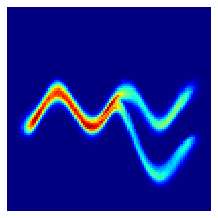

In [2221]:
fig = plt.figure(figsize=(3.75, 3.75))

samples_qK, _ = flow.sample_and_compute_logp(num_samples=int(1e6))
samples_qK = samples_qK.detach().numpy()

plt.hist2d(samples_qK[:,0], samples_qK[:,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])
    
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [2222]:
# copied from stackoverflow
phi = np.linspace(0, 2*np.pi, n)
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = (np.stack((np.cos(phi          ), # Three sinusoids,
                       np.cos(phi+2*np.pi/3), # 120° phase shifted,
                       np.cos(phi-2*np.pi/3)
                      )).T # Shape = (60,3)
             + 1)*0.5   

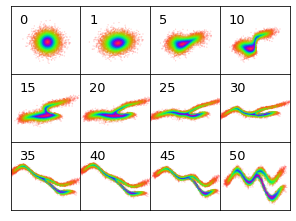

In [2224]:
samples_from_each_layer = flow.sample_from_each_layer(n)
samples_from_each_layer = [samples.detach().numpy() for samples in samples_from_each_layer]

indices = np.argsort(
    (samples_from_each_layer[0][:,0] - flow.μ[0][0].detach().numpy()) ** 2 + 
    (samples_from_each_layer[0][:,1] - flow.μ[0][1].detach().numpy()) ** 2
)

fig = plt.figure(figsize=(5, 5 / 4 * 3), )
for i, j in enumerate([0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]):
    fig.add_subplot(3, 4, i+1)
    plt.scatter(samples_from_each_layer[j][:,0][indices], 
                samples_from_each_layer[j][:,1][indices], 
                color=rgb_cycle,
                s=0.01, alpha=1)
    plt.text(-4.5, 3, f"{j}", size=13)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.xticks([])
    plt.yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig("U4_each_layer.png", dpi=300)

# TODOs

- change mu0 and sigma0 to mu and sigma (done)
- write documentation for batch_sample_from_sylvester_flow
- move small insights into a blog or something